  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  26.9M      0  0:00:02  0:00:02 --:--:-- 26.9M
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
At epoch 1: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('it'), np.str_('if'), np.str_('you')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 181ms/step - loss: 7.3955
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
At epoch 2: 
Predicted tokens:  [np.str_('i'), np.str_('im'), np.str_('my'), np.str_('this'), np.str_('if')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 171ms/step - loss: 6.7728
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
At epoch 3: 
Predicted tokens:  [np.str_('i'), np.str_('ive'), np.str_('this'), np.str_('im'), np.str_('if')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - loss: 6.2823
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
At epoch 4: 
Predicted tokens:  [np.str_('i'), np.str_('i

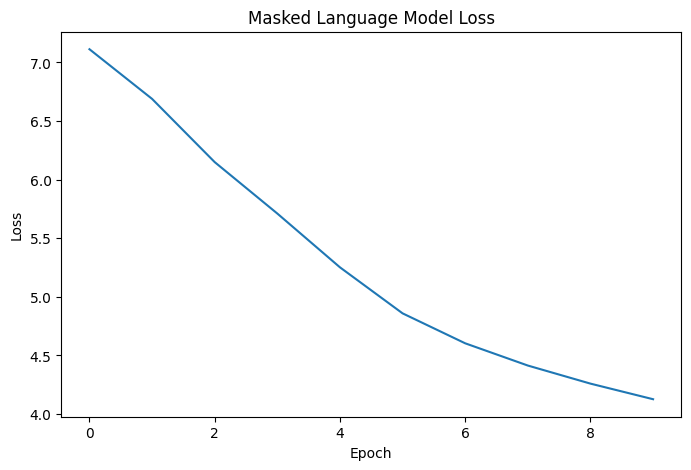

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # Change to "torch" or "jax" if preferred

import keras
from keras import layers
from keras.layers import TextVectorization
from keras.callbacks import EarlyStopping

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

# For data pre-processing and tf.data.Dataset (using TensorFlow for dataset handling)
import tensorflow as tf

# For plotting
import matplotlib.pyplot as plt

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 64
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1

config = Config()

# Download and extract IMDB data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

def get_data_from_text_files(folder_name):
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df

train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = pd.concat([train_df, test_df])

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, r"[!#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]", ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

# We have 25000 examples for training
x_train = encode(train_df.review.values)  # encode reviews (features)
y_train = train_df.sentiment.values  # labels

train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_classifier_ds = test_classifier_ds.batch(config.BATCH_SIZE)


# Build dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for masked language model
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu", name="encoder_{}_ffn_dense_1".format(i)),
            layers.Dense(config.EMBED_DIM, name="encoder_{}_ffn_dense_2".format(i)),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")


class MaskedLanguageModel(keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    embedding_layer = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding")(
        inputs
    )
    position_embedding = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = embedding_layer + position_embedding

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens) # Pass the sample tokens directly
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[0]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        probabilities = mask_prediction[0][top_indices]
        predicted_tokens = [
            self.convert_ids_to_tokens(index) for index in top_indices
        ]
        print("At epoch %d: " % (epoch + 1))
        print("Predicted tokens: ", predicted_tokens)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()

# Train the MLM model and capture history
mlm_history = bert_masked_model.fit(
    mlm_ds,
    epochs=10,
    callbacks=[generator_callback]
)

# Plot MLM loss
plt.figure(figsize=(8, 5))
plt.plot(mlm_history.history['loss'])
plt.title('Masked Language Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

bert_masked_model.save("bert_mlm_imdb.keras")



Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.5681 - loss: 0.8836 - val_accuracy: 0.6584 - val_loss: 0.6198
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6581 - loss: 0.6191 - val_accuracy: 0.6870 - val_loss: 0.5974
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6669 - loss: 0.6110 - val_accuracy: 0.6819 - val_loss: 0.5928
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6824 - loss: 0.5996 - val_accuracy: 0.6938 - val_loss: 0.5837
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6843 - loss: 0.5905 - val_accuracy: 0.6977 - val_loss: 0.5816


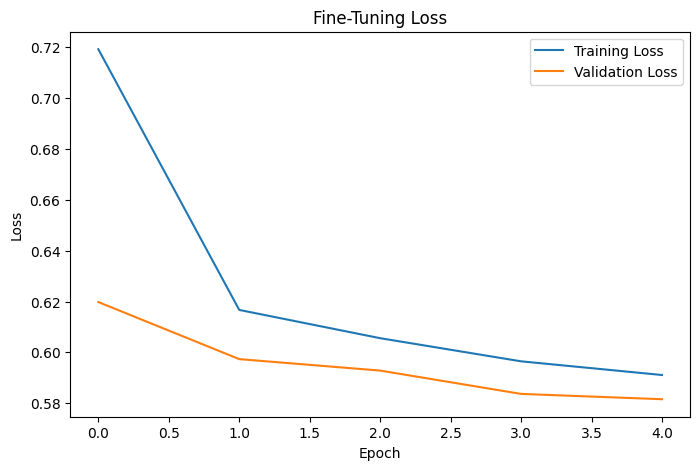

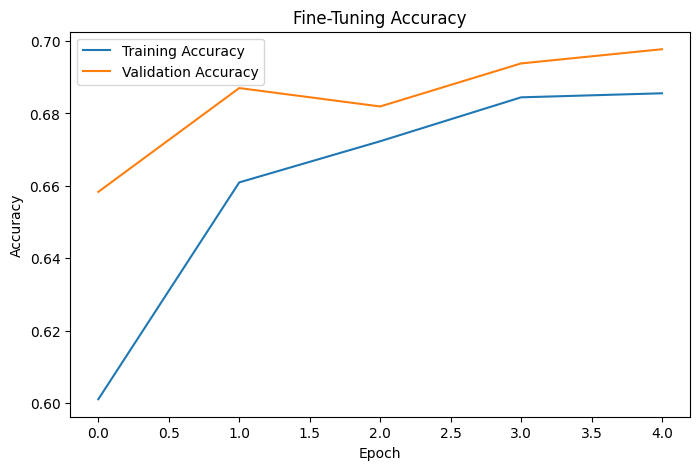

{'accuracy': 0.6977199912071228, 'loss': 0.5815815925598145}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


Public model (DistilBERT SST-2) accuracy: 0.89072


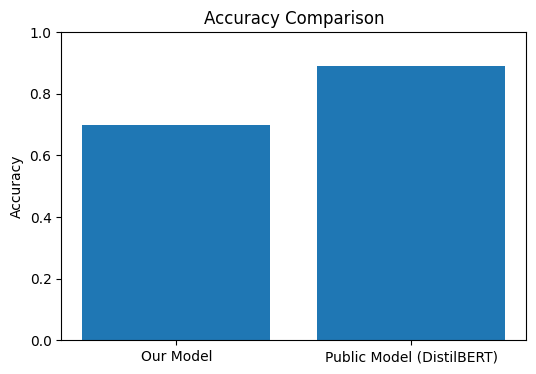

In [2]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    dropout = layers.Dropout(0.1)(hidden_layer)
    outputs = layers.Dense(1, activation="sigmoid")(dropout)
    model = keras.Model(inputs=inputs, outputs=outputs, name="classification")
    return model


fine_tuned_model = create_classifier_bert_model()


fine_tuned_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Fine-tune and capture history
ft_history = fine_tuned_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# Plot fine-tuning loss
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['loss'], label='Training Loss')
plt.plot(ft_history.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot fine-tuning accuracy
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['accuracy'], label='Training Accuracy')
plt.plot(ft_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_results = fine_tuned_model.evaluate(test_classifier_ds, return_dict=True, verbose=0)
print(test_results)

# Install transformers for public model
!pip install -q transformers

# Load a lightweight public model for comparison (DistilBERT fine-tuned on SST-2 for binary sentiment)
from transformers import pipeline
from sklearn.metrics import accuracy_score

public_classifier = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

# Predict on test set (note: this may take some time, but runs on GPU if available in Colab)
public_predictions = public_classifier(test_df.review.tolist(), truncation=True, max_length=512)

# Map 'POSITIVE' to 0, 'NEGATIVE' to 1 (matching our labeling: 0=positive, 1=negative)
pred_labels = [0 if p['label'] == 'POSITIVE' else 1 for p in public_predictions]

# Compute accuracy
public_acc = accuracy_score(y_test, pred_labels)
print(f"Public model (DistilBERT SST-2) accuracy: {public_acc}")

# Compare accuracies visually
plt.figure(figsize=(6, 4))
plt.bar(['Our Model', 'Public Model (DistilBERT)'], [test_results['accuracy'], public_acc])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()